In [82]:
from h5py import *
import numpy as np
from h5utils import *
import matplotlib.pyplot as plt
from fit_functions import *

In [83]:
filename = "measurements/misura_due_risonanze_17_05_30Hz.h5";   # Change HERE!!!

In [84]:
"""PRINT ALL the .h5 file directories"""
h5dump(filename,group = "/");

	 [ 0 ] - <HDF5 group "/" (4 members)>
		 [ 0 ] - <HDF5 group "/Paramp_OFF" (3 members)>
			 [ 0 ] - <HDF5 group "/Paramp_OFF/-15dBm" (1 members)>
				 [ 0 ]- /Paramp_OFF/-15dBm/8.568GHz_8.58GHz_-15dBm : (2, 1598)
			 [ 1 ] - <HDF5 group "/Paramp_OFF/-25dBm" (1 members)>
				 [ 0 ]- /Paramp_OFF/-25dBm/8.568GHz_8.58GHz_-25dBm : (2, 1598)
			 [ 2 ] - <HDF5 group "/Paramp_OFF/-5dBm" (1 members)>
				 [ 0 ]- /Paramp_OFF/-5dBm/8.568GHz_8.58GHz_-5dBm : (2, 1598)
		 [ 1 ] - <HDF5 group "/Paramp_OFF_stretto" (3 members)>
			 [ 0 ] - <HDF5 group "/Paramp_OFF_stretto/-15dBm" (1 members)>
				 [ 0 ]- /Paramp_OFF_stretto/-15dBm/8.572GHz_8.576GHz_-15dBm : (2, 1598)
			 [ 1 ] - <HDF5 group "/Paramp_OFF_stretto/-25dBm" (1 members)>
				 [ 0 ]- /Paramp_OFF_stretto/-25dBm/8.572GHz_8.576GHz_-25dBm : (2, 1598)
			 [ 2 ] - <HDF5 group "/Paramp_OFF_stretto/-5dBm" (1 members)>
				 [ 0 ]- /Paramp_OFF_stretto/-5dBm/8.57GHz_8.574GHz_-5dBm : (2, 1598)
		 [ 2 ] - <HDF5 group "/Paramp_ON" (3 members)>
			 [ 0 ] 

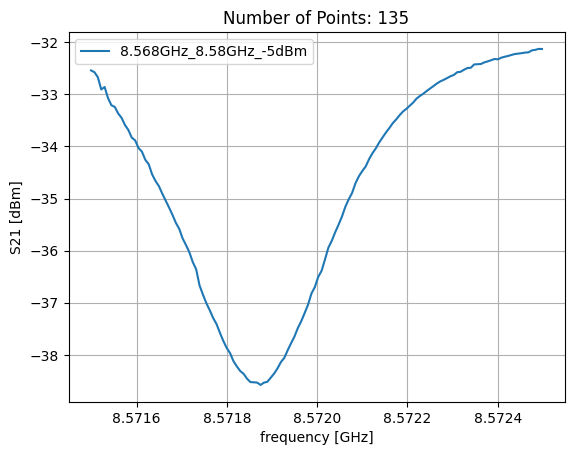

In [85]:
"""GET and plot dataset value"""
group = "/Paramp_ON/-5dBm"
dataset_index = 0   #Selected from the ABOVE (getDatasets(...) method) list!

xs, ys = getDatasetValue(filename,group,dataset_index)
# PLOT
fmin = 8.5715e9
fmax = 8.5725e9
fig, ax = plotDatasetSpectrum(filename, group, dataset_index, fmin, fmax)

# 1) Parabola fit
We consider visually a span where the data seems to resemble a parabola, centered at the freq where visually the minima is. Then we fit a parabola and we consider the $f_{min}$ extimated by the fit:
$$f_{min} = 8.5742933\pm0.0000014 GHz$$
The reported error is the one of the fit, for that reason is very small.

Guess:  [8574300000.0, -37.5, 1] 
Fit extimate:  [ 8.57429337e+09 -3.73844563e+01  3.99704101e-11]
Extimated minima:  8.574293371473706 +- 1.4510850440379002e-06 GHz


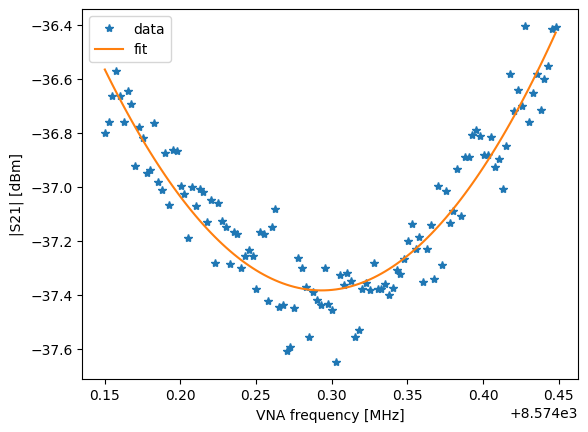

In [86]:
"""FIT a PARABOLA VERY AROUND THE MINIMA"""
# Retrieve data
tempx, tempy = getDatasetValue(filename,group="/Paramp_ON_stretto/-25dBm",dataset_index=0)

# CHOOSE the span to fit
fmin = 8.5743e9-1.5e5   #GHz
fmax = 8.5743e9+1.5e5   #GHz
# fmin, fmax -> i_min, i_max
i_min, i_max = fspan_to_ispan(tempx,fmin,fmax)
# Select the data to FIT
x = tempx[i_min:i_max]
y = tempy[i_min:i_max]

# CHOOSE the guess for the fit parameters 
x0 = 8.5740e9+0.0003e9 #[Hz]
y0 = -37.5 #[dBm]
A = 1 #[1]
popt0 = [x0, y0, A]
popt,pcov = curve_fit(parabola,x,y,popt0,maxfev=2000)

# RESULTS
print("Guess: ",popt0,"\nFit extimate: ",popt)
fig, ax = plt.subplots()
ax.plot(x/1e6,y,'*',label='data')
ax.plot(x/1e6,parabola(x,*popt),label='fit')
ax.set_xlabel('VNA frequency [MHz]')
ax.set_ylabel('|S21| [dBm]')
ax.legend()
print("Extimated minima: ",popt[0]/1e9,"+-",np.sqrt(pcov[0,0])/1e9,"GHz")

# 2) Lorentzian fit subtracting high power and low power measurements
Our measurements got a background due to paramp imperfections. As we expect those imperfections affect the spectrum independently from the VNA power (so the position of the resonant frequency), we expect to see, at any sufficiently high or low VNA power, the same spectrum, with JUST THE RESONANCE in a different place (and different height)

So, in order to REMOVE the background, we subtract a measure at high and one at low power.
After this operation, we expect a *FLAT* spectrum, with JUST THE TWO RESONANCES (one of them is positive, because we make the difference)

Then we fit with two displaced Lorentz, but the fit evidently gives an extimate of the dressed frequency _SMALLER_ than the right one:
$$f_{dressed} = 8.574192 \pm 0.000004 GHz$$
The reported error is the one of the fit, for that reason is very small.

It differs from the parabola fit extimation for *less than* a 0.2MHz.

Anyway the double Lorentzian fit seems to be not so good. So it seems that the Overlap of the 2 resonance curves is not the (only) effect for the asymmetricity of the [dressed] peak. 

Text(0.5, 1.0, 'Trasmission spectrum\nfor -5dBm [bare] MINUS for -25dBm [dressed]')

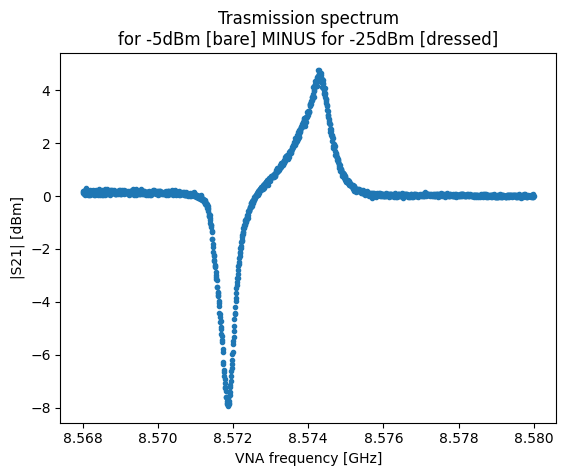

In [87]:
"""SUBTRACT MEASUREMENTS WHERE THE RESONANCE IS IN THE TWO DIFFERENT PLACES"""
tempx, ydress = getDatasetValue(filename,group="/Paramp_ON/-25dBm",dataset_index=0)
tempx, ybare = getDatasetValue(filename,group="/Paramp_ON/-5dBm",dataset_index=0)
tempy = ybare - ydress
#freq0, yinterm = getDatasetValue(filename,group="/Paramp_ON/-15dBm",dataset_index=0)

fig, ax = plt.subplots()
ax.plot(tempx/1e9,tempy,'.')
ax.set_xlabel('VNA frequency [GHz]')
ax.set_ylabel('|S21| [dBm]')
ax.set_title('Trasmission spectrum\nfor -5dBm [bare] MINUS for -25dBm [dressed]')

Guess:  [8575300000.0, 8571800000.0, 500000.0, 100000.0, 2500000.0, -800000.0] 
Fit extimate:  [ 8.57419152e+09  8.57185609e+09  4.70233429e+05  2.03914408e+05
  2.06183903e+06 -1.69993866e+06]
Extimated minima:  8.574191523283154 +- 3.831288256407767e-06 GHz


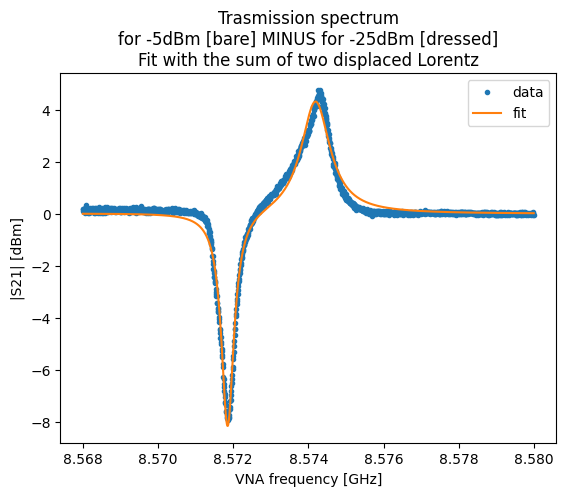

In [88]:
"""FIT DOUBLE LORENTZ (execute section above before!)"""
# CHOOSE the span to fit
fmin = 0   #[GHz]
fmax = 9e9   #[GHz]
# fmin, fmax -> i_min, i_max
i_min, i_max = fspan_to_ispan(tempx,fmin,fmax)
# Select the data to FIT
x = tempx[i_min:i_max]
y = tempy[i_min:i_max]

# CHOOSE the guess for the fit parameters 
x0 = 8.5753e9
y0 = 8.5718e9
g1 = 0.5e6
g2 = 0.1e6
A1 = g1*5
A2 = -8*g2
popt0 = [x0,y0,g1,g2,A1,A2]
popt,pcov = curve_fit(double_lorentz,x,y,popt0,maxfev=2000)

# RESULTS
print("Guess: ",popt0,"\nFit extimate: ",popt)
fig, ax = plt.subplots()
ax.plot(x/1e9,y,'.',label='data')
ax.plot(x/1e9,double_lorentz(x,*popt),label='fit')
ax.set_xlabel('VNA frequency [GHz]')
ax.set_ylabel('|S21| [dBm]')
ax.set_title('Trasmission spectrum\nfor -5dBm [bare] MINUS for -25dBm [dressed]\nFit with the sum of two displaced Lorentz')
ax.legend()
print("Extimated minima: ",popt[0]/1e9,"+-",np.sqrt(pcov[0,0])/1e9,"GHz")

# 3) Remove the background from the dressed (-25dBm) measure subtracting the bare (-5dBm) measure JUST AWAY from the two resonances (And viceversa)
The frequency span that contains BOTH the resonances is excluded from the difference!

In the "middle region" we take the difference between the dressed measurement (-25dBm) and the average of the extremes of the bare measurement (-5dBm), otherwise we would have 2 flat frequency spans right and left, and in the middle data would be SHIFTED

Evidently it does not work for properly for the [bare] frequency extimation, but we can try for the [dressed] frequency.

Text(0.5, 1.0, 'Trasmission spectrum where\ndifference betwerren the curves is made\nfar from their respective resonances')

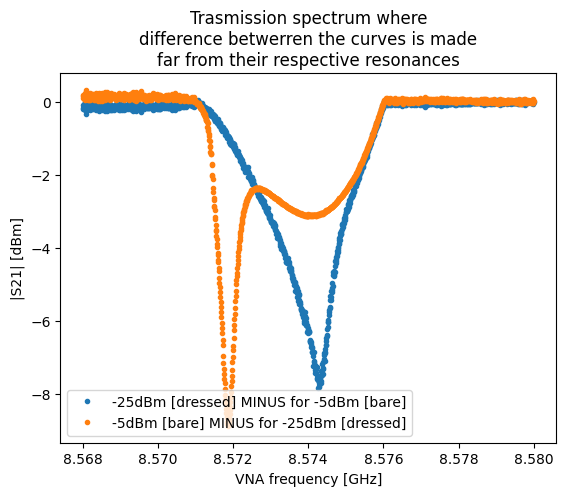

In [89]:
"""SUBTRACT MEASUREMENTS TO REMOVE Background JUST AWAY from the resonances"""
tempx, ydress = getDatasetValue(filename,group="/Paramp_ON/-25dBm",dataset_index=0)
tempx, ybare = getDatasetValue(filename,group="/Paramp_ON/-5dBm",dataset_index=0)

### [DRESSED]
# Select the region where the difference MUST NOT be taken
fmin = 8.571e9 #[Hz]
fmax = 8.576e9 #[Hz]
# Take the difference
i_min, i_max = fspan_to_ispan(tempx,fmin,fmax)
y1 = ydress[0:i_min] - ybare[0:i_min]
y2 = ydress[i_min:i_max] - (ybare[i_min]+ybare[i_max])/2    #In the MIDDLE REGION we subtract the mean of the extremes
y3 = ydress[i_max:len(ydress)] - ybare[i_max:len(ybare)]
newydress = np.append(y1,y2)
newydress = np.append(newydress,y3)

### [BARE]
# Select the region where the difference MUST NOT be taken
fmin = 8.571e9 #[Hz]
fmax = 8.576e9 #[Hz]
# Take the difference
i_min, i_max = fspan_to_ispan(tempx,fmin,fmax)
y1 = ybare[0:i_min] - ydress[0:i_min]
y2 = ybare[i_min:i_max] - (ybare[i_min]+ybare[i_max])/2    #In the MIDDLE REGION we subtract the mean of the extremes
y3 = ybare[i_max:len(ybare)] - ydress[i_max:len(ybare)]
newybare = np.append(y1,y2)
newybare = np.append(newybare,y3)

# RESULT
fig1, ax = plt.subplots()
ax.plot(tempx/1e9,newydress,'.',label='-25dBm [dressed] MINUS for -5dBm [bare]')
ax.plot(tempx/1e9,newybare,'.',label='-5dBm [bare] MINUS for -25dBm [dressed]')
ax.legend()
ax.set_xlabel('VNA frequency [GHz]')
ax.set_ylabel('|S21| [dBm]')
ax.set_title('Trasmission spectrum where\ndifference betwerren the curves is made\nfar from their respective resonances')

## Here we fit with a 'solo Lorentz' and then with 'Lorentz + deg(4) poly'
- With only the Lorentz, we achieve a good fit at _least around the minima_ for the [bare] frequency curve:
$$\omega_{bare} = 8.571888 \pm 0.000007 GHz$$
where the error is so small, because we took the one from the fit. The fit is not good over the entire frequency span used for the fit, but at least the frequency of the peak (that is what we're looking for) seems to be well extimated by the fit.
We remind we're not intersted in checking the laws of physics, we're just exploiting what we expect from the theory to get a better way to extimate the center frequency of the resonance, that we need to know approximately to perform quantum computing. 

While the [dressed] curve is not well fitted by only the Lorentz.
- With Lorentz + poly of deg(4), we achieve a better fit for the [dressed] frequency curve:
$$\omega_{dressed} = 8.5742662 \pm 0.0000019 GHz$$
anyway the added polynomial adds a contribution that is not small respect to the Lorentz contribution.

Solo Lorentz fit, minima extimate:  8.571888190945005 +- 7.176302848756713e-06 GHz
Poly coefficients from the Highest degree: [-3.06115651e-23  5.82956823e-19  7.27111789e-11 -4.43147760e-05
  0.00000000e+00]


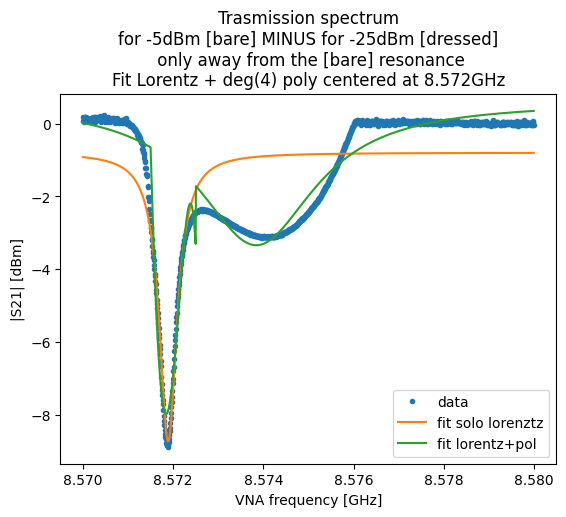

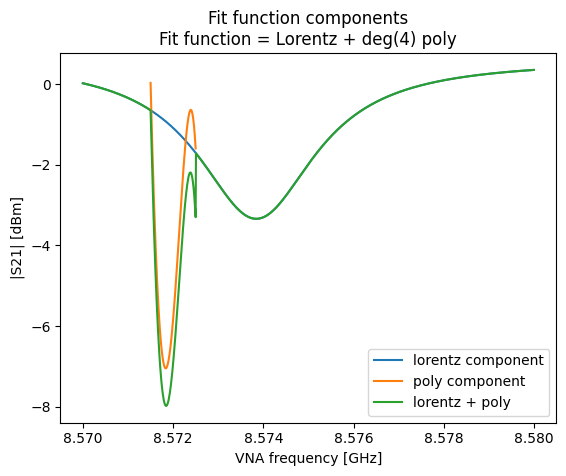

In [90]:
"""FIT poly_lorentz [BARE]"""

# Fit the Poly only in the non-flat region
fmin = 8.5715e9 #[Hz]
fmax = 8.5725e9 #[Hz]

# Select fspan to fit
fminfit = 8.570e9
fmaxfit = 8.580e9
i_min, i_max = fspan_to_ispan(tempx,fminfit,fmaxfit)
x = tempx[i_min:i_max]
y = newybare[i_min:i_max] # [BARE]

# Parameters guess
x0 = 8.5718e9
g = 0.2e6
A = -g*6
offset = 0

# First fit round (no poly):
popt0 = [x0,g,A,offset]
popt0, pcov = curve_fit(lorentz,x,y,popt0,maxfev=2000)
print("Solo Lorentz fit, minima extimate: ",popt0[0]/1e9,"+-",np.sqrt(pcov[0,0])/1e9,"GHz")
# Second fit round (w/ added poly):
p1=0; p2=0; p3=0; p4=0;
popt0 = np.append(popt0, [p1,p2,p3,p4])
#param_bounds=((-np.inf,-np.inf,-np.inf,-np.inf,0,0,0,0),(np.inf,np.inf,np.inf,np.inf,0.1,0.1,0.1,0.1))
popt, pcov = curve_fit(lambda x,x0,g,A,offset,p1,p2,p3,p4: pol_lorentz(x,x0,g,A,offset,p1,p2,p3,p4,fmin,fmax),x,y,popt0,maxfev=2000)

# Results
fig, ax = plt.subplots()
ax.plot(x/1e9,y,'.',label='data')
ax.plot(x/1e9,lorentz(x,popt0[0],popt0[1],popt0[2],popt0[3]),label='fit solo lorenztz')
ax.plot(x/1e9,pol_lorentz(x,*popt,fmin,fmax),label='fit lorentz+pol')
ax.set_xlabel('VNA frequency [GHz]')
ax.set_ylabel('|S21| [dBm]')
ax.set_title('Trasmission spectrum\nfor -5dBm [bare] MINUS for -25dBm [dressed]\n only away from the [bare] resonance\nFit Lorentz + deg(4) poly centered at '+str(round(fmin/1e9,3))+'GHz')
ax.legend()


# Show the added polynomial
fig_pol, ax_pol = plt.subplots()
# Plot the polynomial just in the [fmin,fmax] span
i_min, i_max = fspan_to_ispan(tempx, fmin, fmax)
x_pol = tempx[i_min:i_max]
# Define the polynomial (and plot it)
ps = np.append(offset,popt[4:len(popt)])
ps = ps[::-1]   # Reverse the array
ax_pol.plot(x/1e9,lorentz(x,popt[0],popt[1],popt[2],popt[3]),label='lorentz component')
ax_pol.plot(x_pol/1e9,np.polyval(ps,x_pol-np.ones(len(x_pol))*fmin),label='poly component')
ax_pol.plot(x/1e9,pol_lorentz(x,*popt,fmin,fmax),label='lorentz + poly')
#ax_pol.plot(x/1e9,lorentz(x,popt[0],popt[1],popt[2],popt[3])+np.polyval(ps,x-fmin),label='lorentz + poly (manual)')
ax_pol.set_xlabel('VNA frequency [GHz]')
ax_pol.set_ylabel('|S21| [dBm]')
ax_pol.set_title('Fit function components\nFit function = Lorentz + deg(4) poly')
ax_pol.legend()
print("Poly coefficients from the Highest degree:", ps)

Lorentz + poly deg(4) fit, minima extimate:  8.574266188452233 +- 1.8805938042346544e-06 GHz
Poly coefficients from the Highest degree: [-6.31913205e-26  7.32987136e-19 -2.17667494e-12  4.67124632e-07
  0.00000000e+00]


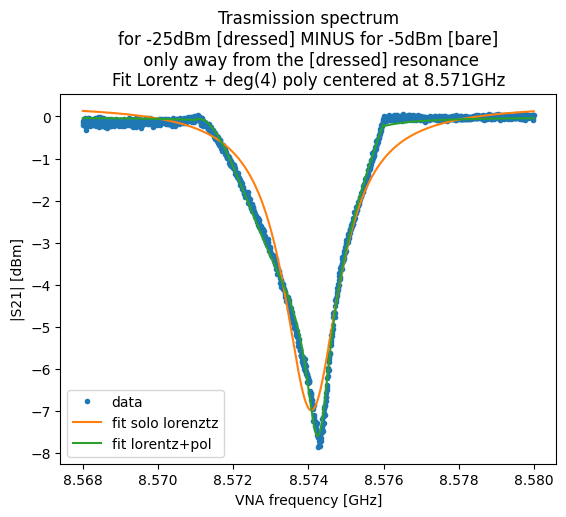

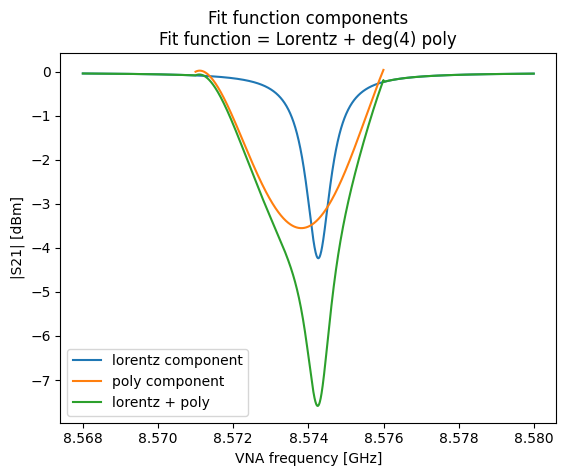

In [91]:
"""FIT poly_lorentz [DRESS]"""

# Fit the Poly only in the non-flat region
fmin = 8.571e9 #[Hz]
fmax = 8.576e9 #[Hz]

# Select fspan to fit
fminfit = 8.568e9
fmaxfit = 8.580e9
i_min, i_max = fspan_to_ispan(tempx,fminfit,fmaxfit)
x = tempx[i_min:i_max]
y = newydress[i_min:i_max] # [DRESSED]

# Parameters guess
x0 = 8.574e9
g = 0.5e6
A = g*(-8)
offset = 0

# First fit round (no poly):
popt0 = [x0,g,A,offset]
popt0, pcov = curve_fit(lorentz,x,y,popt0,maxfev=2000)
# Second fit round (w/ added poly):
p1=0; p2=0; p3=0; p4=0; p5=0; p6=0
popt0 = np.append(popt0, [p1,p2,p3,p4])
#param_bounds=((-np.inf,-np.inf,-np.inf,-np.inf,0,0,0,0),(np.inf,np.inf,np.inf,np.inf,0.1,0.1,0.1,0.1))
popt, pcov = curve_fit(lambda x,x0,g,A,offset,p1,p2,p3,p4: pol_lorentz(x,x0,g,A,offset,p1,p2,p3,p4,fmin,fmax),x,y,popt0,maxfev=2000)

# Results
fig, ax = plt.subplots()
ax.plot(x/1e9,y,'.',label='data')
ax.plot(x/1e9,lorentz(x,popt0[0],popt0[1],popt0[2],popt0[3]),label='fit solo lorenztz')
ax.plot(x/1e9,pol_lorentz(x,*popt,fmin,fmax),label='fit lorentz+pol')
ax.set_xlabel('VNA frequency [GHz]')
ax.set_ylabel('|S21| [dBm]')
ax.set_title('Trasmission spectrum\nfor -25dBm [dressed] MINUS for -5dBm [bare]\n only away from the [dressed] resonance\nFit Lorentz + deg(4) poly centered at '+str(round(fmin/1e9,3))+'GHz')
ax.legend()

print("Lorentz + poly deg(4) fit, minima extimate: ",popt[0]/1e9,"+-",np.sqrt(pcov[0,0])/1e9,"GHz")

# Show the added polynomial
fig_pol, ax_pol = plt.subplots()
# Plot the polynomial just in the [fmin,fmax] span
i_min, i_max = fspan_to_ispan(tempx, fmin, fmax)
x_pol = tempx[i_min:i_max]
# Define the polynomial (and plot it)
ps = np.append(offset,popt[4:len(popt)])
ps = ps[::-1]   # Reverse the array
ax_pol.plot(x/1e9,lorentz(x,popt[0],popt[1],popt[2],popt[3]),label='lorentz component')
ax_pol.plot(x_pol/1e9,np.polyval(ps,x_pol-np.ones(len(x_pol))*fmin),label='poly component')
ax_pol.plot(x/1e9,pol_lorentz(x,*popt,fmin,fmax),label='lorentz + poly')
#ax_pol.plot(x/1e9,lorentz(x,popt[0],popt[1],popt[2],popt[3])+np.polyval(ps,x-fmin),label='lorentz + poly (manual)')
ax_pol.set_xlabel('VNA frequency [GHz]')
ax_pol.set_ylabel('|S21| [dBm]')
ax_pol.set_title('Fit function components\nFit function = Lorentz + deg(4) poly')
ax_pol.legend()
print("Poly coefficients from the Highest degree:", ps)

# 4) Remove the background with a polynomial fit (away from the resonance)
NOTE: Fitting w/ poly the bare data away from the bare frequency we get the background extimate that we use for BOTH bare and dressed. We choose the bare one because the dressed peak is wider than the bare peak.

In the frequency span of the bare peak, we use for the fit the points of the Dressed curve measure. We do not leave this region without points, because the otherwise the fit curve in this region seems unfaithful to what visually seems to be the background.

Anyway the result of this procedure for the dressed curve has an 'additional small peak' near the resonance peak, while we expect something flat.

Text(0.5, 1.0, 'Trasmission spectrum [BG removed]')

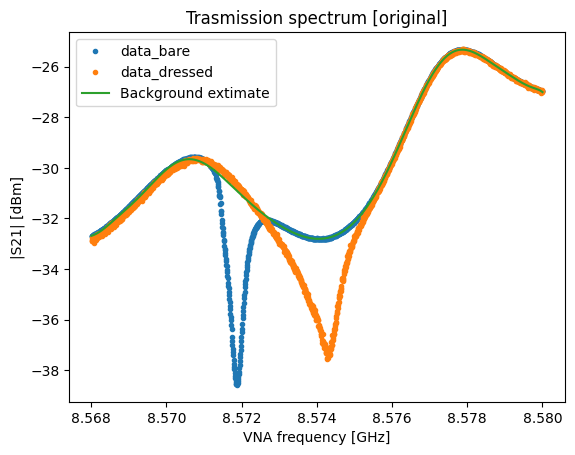

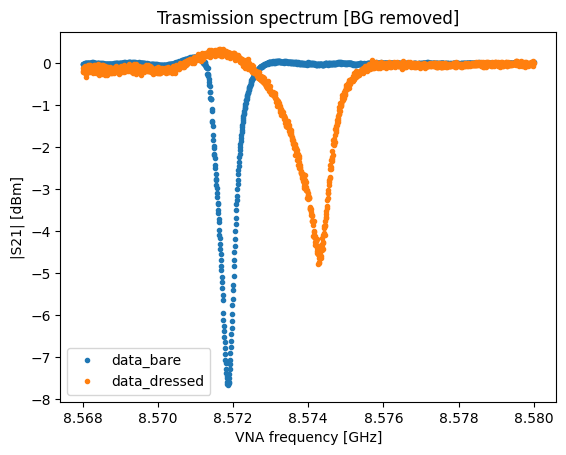

In [92]:
"""FIT [bare data] WITH A POLY THE POINTS AWAY FROM [bare] RESONANCE TO EXTIMATE THE Background"""
tempx, ydress = getDatasetValue(filename,group="/Paramp_ON/-25dBm",dataset_index=0)
tempx, ybare = getDatasetValue(filename,group="/Paramp_ON/-5dBm",dataset_index=0)

### [Consider [bare] data]
# Select the points AWAY from the resonance
fmin = 8.5715e9 #[Hz]
fmax = 8.5725e9 #[Hz]
i_min, i_max = fspan_to_ispan(tempx,fmin,fmax)
# x = np.append(tempx[0:i_min], tempx[i_max:len(ydress)])
# y = np.append(ybare[0:i_min], ybare[i_max:len(ydress)])
x = tempx
y = np.append(ybare[0:i_min], ydress[i_min:i_max])
y = np.append(y, ybare[i_max:len(ybare)])
deg = 16 # Degree of fitted poly
ps = np.polyfit(x-np.ones(len(x))*tempx[0],y,deg)

# Results
fig, ax = plt.subplots()
ax.plot(tempx/1e9,ybare,'.',label='data_bare')
ax.plot(tempx/1e9,ydress,'.',label='data_dressed')
ax.plot(tempx/1e9,np.polyval(ps,tempx-np.ones(len(tempx))*tempx[0]),label='Background extimate')
ax.legend()
ax.set_xlabel('VNA frequency [GHz]')
ax.set_ylabel('|S21| [dBm]')
ax.set_title('Trasmission spectrum [original]')

# Show data Removing the extimated background
newydress = ydress - np.polyval(ps,tempx-np.ones(len(tempx))*tempx[0])
newybare = ybare - np.polyval(ps,tempx-np.ones(len(tempx))*tempx[0])
fig_pol, ax_pol = plt.subplots()
ax_pol.plot(tempx/1e9,newybare,'.',label='data_bare')
ax_pol.plot(tempx/1e9,newydress,'.',label='data_dressed')
ax_pol.legend()
ax_pol.set_xlabel('VNA frequency [GHz]')
ax_pol.set_ylabel('|S21| [dBm]')
ax_pol.set_title('Trasmission spectrum [BG removed]')

## Now we fit with Lorentz + poly of deg(4)
For both curves, the polynomial component of the fit is small compared with the Lorentzian.
$$\omega_{bare} = 8.571882 \pm 0.000003 GHz$$
$$\omega_{dressed} = 8.574265 \pm 0.000002 GHz$$

Lorentz + poly deg(4) fit, minima extimate:  8.571882290825878 +- 2.7574608004958234e-06 GHz
Poly coefficients from the Highest degree: [ 3.46474074e-23 -8.55115588e-17  7.08630538e-11 -1.98494624e-05
  0.00000000e+00]


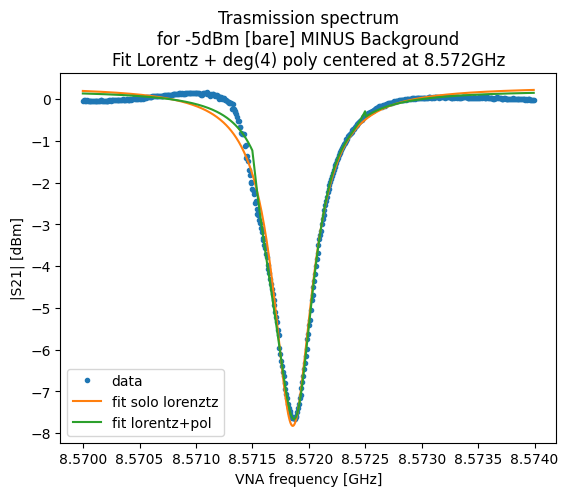

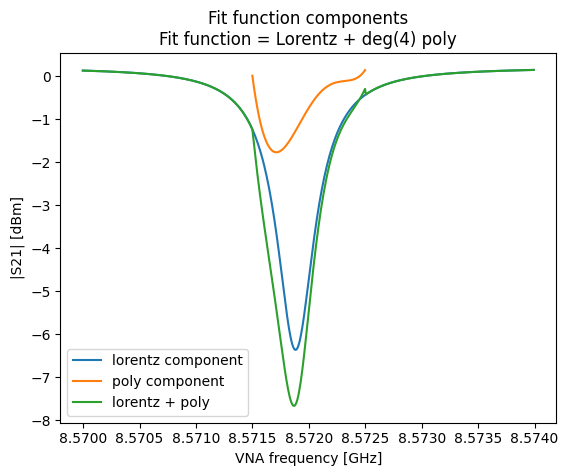

In [93]:
"""FIT poly_lorentz [BARE]"""

# Fit the Poly only in the non-flat region
fmin = 8.5715e9 #[Hz]
fmax = 8.5725e9 #[Hz]

# Select fspan to fit
fminfit = 8.570e9
fmaxfit = 8.574e9
i_min, i_max = fspan_to_ispan(tempx,fminfit,fmaxfit)
x = tempx[i_min:i_max]
y = newybare[i_min:i_max] # [BARE]

# Parameters guess
x0 = 8.5718e9
g = 0.2e6
A = -g*6
offset = 0

# First fit round (no poly):
popt0 = [x0,g,A,offset]
popt0, pcov = curve_fit(lorentz,x,y,popt0,maxfev=2000)
# Second fit round (w/ added poly):
p1=0; p2=0; p3=0; p4=0;
popt0 = np.append(popt0, [p1,p2,p3,p4])
#param_bounds=((-np.inf,-np.inf,-np.inf,-np.inf,0,0,0,0),(np.inf,np.inf,np.inf,np.inf,0.1,0.1,0.1,0.1))
popt, pcov = curve_fit(lambda x,x0,g,A,offset,p1,p2,p3,p4: pol_lorentz(x,x0,g,A,offset,p1,p2,p3,p4,fmin,fmax),x,y,popt0,maxfev=2000)

# Results
fig, ax = plt.subplots()
ax.plot(x/1e9,y,'.',label='data')
ax.plot(x/1e9,lorentz(x,popt0[0],popt0[1],popt0[2],popt0[3]),label='fit solo lorenztz')
ax.plot(x/1e9,pol_lorentz(x,*popt,fmin,fmax),label='fit lorentz+pol')
ax.set_xlabel('VNA frequency [GHz]')
ax.set_ylabel('|S21| [dBm]')
ax.set_title('Trasmission spectrum\nfor -5dBm [bare] MINUS Background\nFit Lorentz + deg(4) poly centered at '+str(round(fmin/1e9,3))+'GHz')
ax.legend()

print("Lorentz + poly deg(4) fit, minima extimate: ",popt[0]/1e9,"+-",np.sqrt(pcov[0,0])/1e9,"GHz")

# Show the added polynomial
fig_pol, ax_pol = plt.subplots()
# Plot the polynomial just in the [fmin,fmax] span
i_min, i_max = fspan_to_ispan(tempx, fmin, fmax)
x_pol = tempx[i_min:i_max]
# Define the polynomial (and plot it)
ps = np.append(offset,popt[4:len(popt)])
ps = ps[::-1]   # Reverse the array
ax_pol.plot(x/1e9,lorentz(x,popt[0],popt[1],popt[2],popt[3]),label='lorentz component')
ax_pol.plot(x_pol/1e9,np.polyval(ps,x_pol-np.ones(len(x_pol))*fmin),label='poly component')
ax_pol.plot(x/1e9,pol_lorentz(x,*popt,fmin,fmax),label='lorentz + poly')
#ax_pol.plot(x/1e9,lorentz(x,popt[0],popt[1],popt[2],popt[3])+np.polyval(ps,x-fmin),label='lorentz + poly (manual)')
ax_pol.set_xlabel('VNA frequency [GHz]')
ax_pol.set_ylabel('|S21| [dBm]')
ax_pol.set_title('Fit function components\nFit function = Lorentz + deg(4) poly')
ax_pol.legend()
print("Poly coefficients from the Highest degree:", ps)

Lorentz + poly deg(4) fit, minima extimate:  8.574265332164861 +- 1.967051564071465e-06 GHz
Poly coefficients from the Highest degree: [-6.61788284e-26  6.77672021e-19 -2.09888963e-12  1.83217309e-06
  0.00000000e+00]


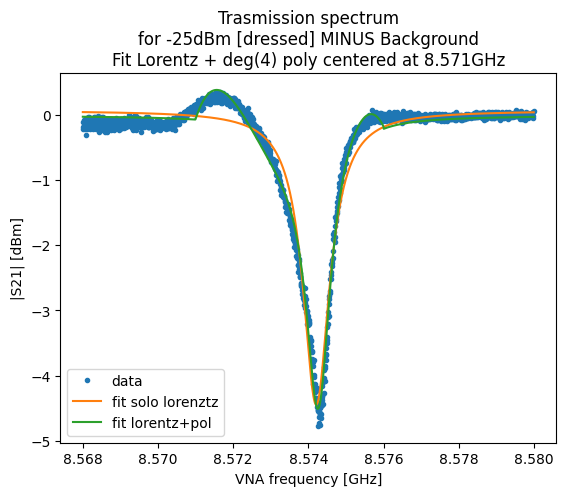

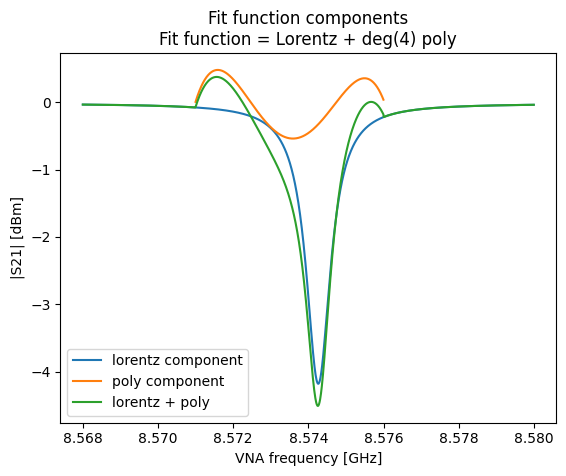

In [94]:
"""FIT poly_lorentz [DRESS]"""

# Fit the Poly only in the non-flat region
fmin = 8.571e9 #[Hz]
fmax = 8.576e9 #[Hz]

# Select fspan to fit
fminfit = 8.568e9
fmaxfit = 8.580e9
i_min, i_max = fspan_to_ispan(tempx,fminfit,fmaxfit)
x = tempx[i_min:i_max]
y = newydress[i_min:i_max] # [DRESSED]

# Parameters guess
x0 = 8.574e9
g = 0.5e6
A = g*(-8)
offset = 0

# First fit round (no poly):
popt0 = [x0,g,A,offset]
popt0, pcov = curve_fit(lorentz,x,y,popt0,maxfev=2000)
# Second fit round (w/ added poly):
p1=0; p2=0; p3=0; p4=0; p5=0; p6=0
popt0 = np.append(popt0, [p1,p2,p3,p4])
#param_bounds=((-np.inf,-np.inf,-np.inf,-np.inf,0,0,0,0),(np.inf,np.inf,np.inf,np.inf,0.1,0.1,0.1,0.1))
popt, pcov = curve_fit(lambda x,x0,g,A,offset,p1,p2,p3,p4: pol_lorentz(x,x0,g,A,offset,p1,p2,p3,p4,fmin,fmax),x,y,popt0,maxfev=2000)

# Results
fig, ax = plt.subplots()
ax.plot(x/1e9,y,'.',label='data')
ax.plot(x/1e9,lorentz(x,popt0[0],popt0[1],popt0[2],popt0[3]),label='fit solo lorenztz')
ax.plot(x/1e9,pol_lorentz(x,*popt,fmin,fmax),label='fit lorentz+pol')
ax.set_xlabel('VNA frequency [GHz]')
ax.set_ylabel('|S21| [dBm]')
ax.set_title('Trasmission spectrum\nfor -25dBm [dressed] MINUS Background\nFit Lorentz + deg(4) poly centered at '+str(round(fmin/1e9,3))+'GHz')
ax.legend()

print("Lorentz + poly deg(4) fit, minima extimate: ",popt[0]/1e9,"+-",np.sqrt(pcov[0,0])/1e9,"GHz")

# Show the added polynomial
fig_pol, ax_pol = plt.subplots()
# Plot the polynomial just in the [fmin,fmax] span
i_min, i_max = fspan_to_ispan(tempx, fmin, fmax)
x_pol = tempx[i_min:i_max]
# Define the polynomial (and plot it)
ps = np.append(offset,popt[4:len(popt)])
ps = ps[::-1]   # Reverse the array
ax_pol.plot(x/1e9,lorentz(x,popt[0],popt[1],popt[2],popt[3]),label='lorentz component')
ax_pol.plot(x_pol/1e9,np.polyval(ps,x_pol-np.ones(len(x_pol))*fmin),label='poly component')
ax_pol.plot(x/1e9,pol_lorentz(x,*popt,fmin,fmax),label='lorentz + poly')
#ax_pol.plot(x/1e9,lorentz(x,popt[0],popt[1],popt[2],popt[3])+np.polyval(ps,x-fmin),label='lorentz + poly (manual)')
ax_pol.set_xlabel('VNA frequency [GHz]')
ax_pol.set_ylabel('|S21| [dBm]')
ax_pol.set_title('Fit function components\nFit function = Lorentz + deg(4) poly')
ax_pol.legend()
print("Poly coefficients from the Highest degree:", ps)